###### Importing the libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings 
warnings.filterwarnings('ignore')

###### Loading & Understanding the dataset

In [2]:
big_mart = pd.read_csv('Train.csv')

In [3]:
big_mart.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


There are 12 columns, some are numeric while some are categorical.
- Numeric columns:
The following ones are features- 

1) Item_Weight - indicates the weight of each item.

2) Item_Visibility - indicates the degree of visibility of each item.

3) Item_MRP - indicates the price of each item.

4) Outlet_Establishment_Year - indicates the year of establishment of the outlet.

This is the target variable-

5) Item_Outlet_Sales  - indicates the sales of the particular item at a particular outlet. 

- Categorical columns:
 
6) Item_Identifier :  indicates categories of different products

7) Item_Fat_Content : indicates fat content of product

8) Item_Type : indicates the type of the item

9) Outlet_Identifier : indicates unique ID of the outlet

10) Outlet_Size :indicates the size of the outlet

11) Outlet_Location_Type : indicates in what kind of city the outlet is located in

12) Outlet_Type : indicates the kind of outlet 


In [4]:
big_mart.shape

(8523, 12)

In [5]:
big_mart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


There are two columns with missing values

We can visualize the pattern of how these missing values are distributed in the given columns

<Figure size 1080x1080 with 0 Axes>

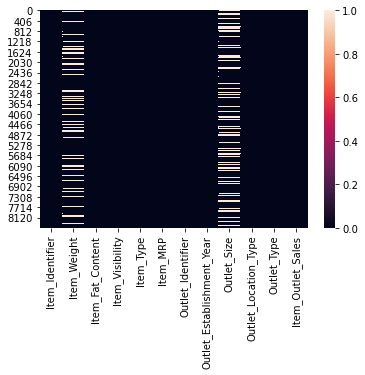

<Figure size 1080x1080 with 0 Axes>

In [6]:
sns.heatmap(big_mart.isnull())
plt.figure(figsize = (15,15))

In [7]:
big_mart.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Data Imputation 
- We group by the item type and find the mean to replace the NaN values

In [8]:
big_mart.groupby('Item_Type')['Item_Weight'].mean()

Item_Type
Baking Goods             12.277108
Breads                   11.346936
Breakfast                12.768202
Canned                   12.305705
Dairy                    13.426069
Frozen Foods             12.867061
Fruits and Vegetables    13.224769
Hard Drinks              11.400328
Health and Hygiene       13.142314
Household                13.384736
Meat                     12.817344
Others                   13.853285
Seafood                  12.552843
Snack Foods              12.987880
Soft Drinks              11.847460
Starchy Foods            13.690731
Name: Item_Weight, dtype: float64

In [9]:
big_mart['Item_Weight'] = big_mart.groupby('Item_Type')['Item_Weight'].apply(lambda x:x.fillna(x.mean()))

In [10]:
big_mart['Item_Weight'].hasnans

False

- We find the mode of each Outlet Size wrt Outlet Type and replace the missing values in Outlet Size columns in that manner


In [11]:
big_mart['Outlet_Size'].mode()

0    Medium
dtype: object

In [12]:
mode_Outlet_size = big_mart.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [13]:
mode_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [14]:
missing_values = big_mart['Outlet_Size'].isnull()

In [15]:
missing_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [16]:
big_mart.loc[missing_values, 'Outlet_Size'] = big_mart.loc[missing_values,'Outlet_Type'].apply(lambda x: mode_Outlet_size[x])

In [17]:
big_mart['Outlet_Size'].hasnans

False

- We notice that there are only two main types of low fat and regular 

In [18]:
big_mart['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [19]:
big_mart['Item_Fat_Content'] = big_mart['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat','reg':'Regular'})

In [20]:
big_mart['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

###### Statistical Description

In [21]:
big_mart.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


##### Data Visualization

- Univariate Visualize


Numeric Data Types

In [22]:
big_mart.skew()

Item_Weight                  0.089537
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
dtype: float64

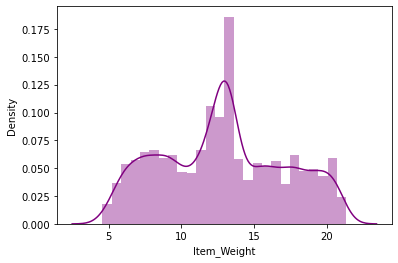

In [23]:
sns.distplot(big_mart['Item_Weight'], color='purple')
plt.show()

<AxesSubplot:xlabel='Item_Visibility', ylabel='Density'>

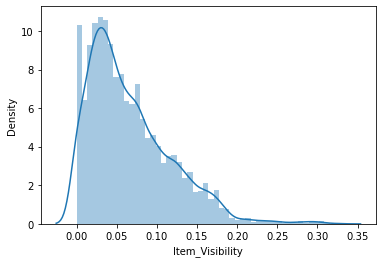

In [24]:
sns.distplot(big_mart['Item_Visibility'])

<AxesSubplot:xlabel='Item_MRP', ylabel='Density'>

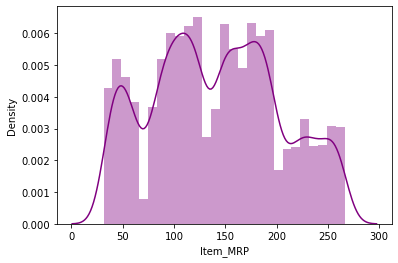

In [25]:
sns.distplot(big_mart['Item_MRP'],color='purple')

- Categorical Type

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

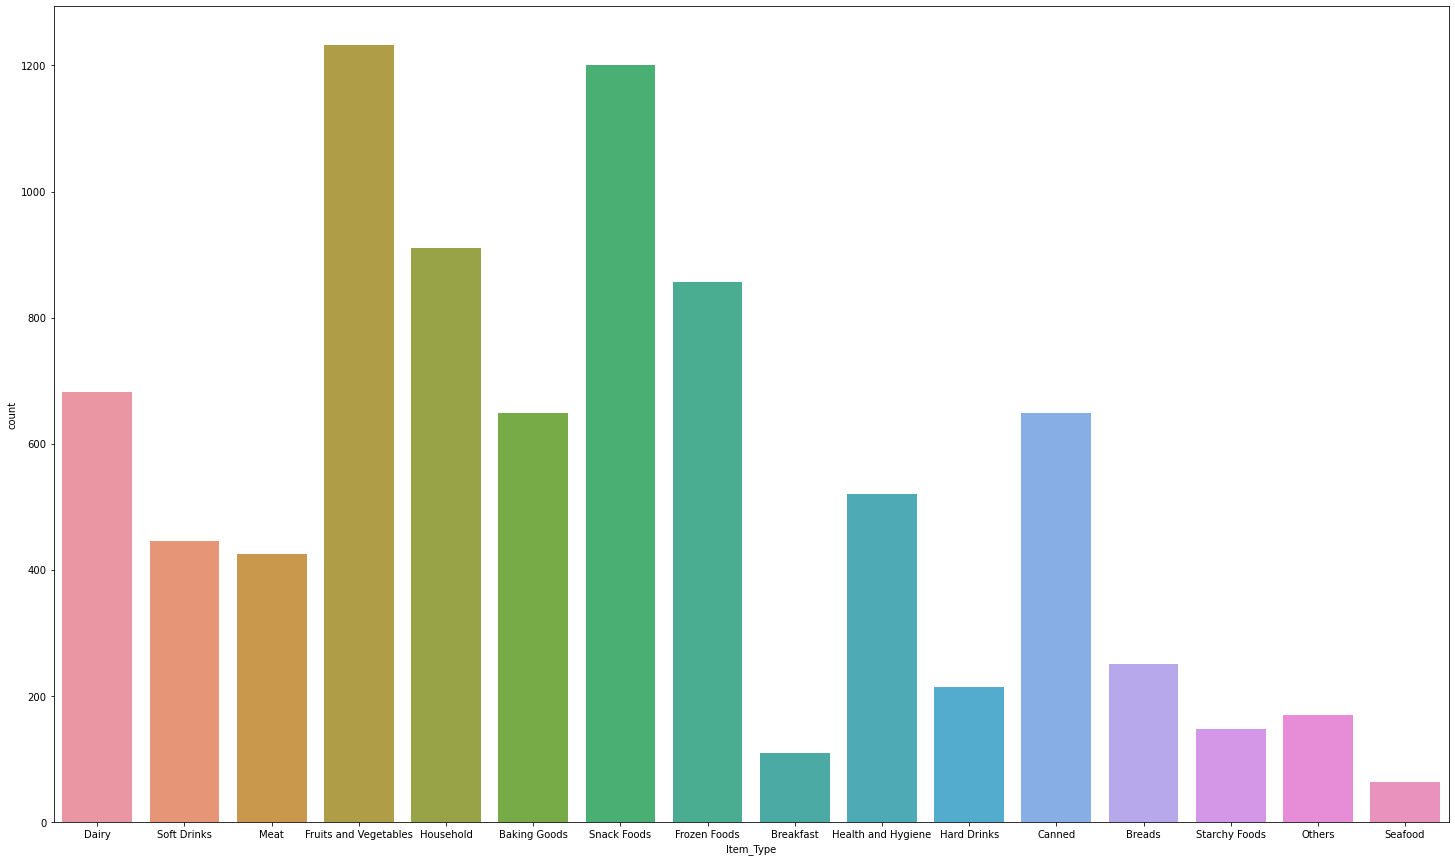

In [26]:
plt.figure(figsize = (25,15))
sns.countplot('Item_Type', data = big_mart)

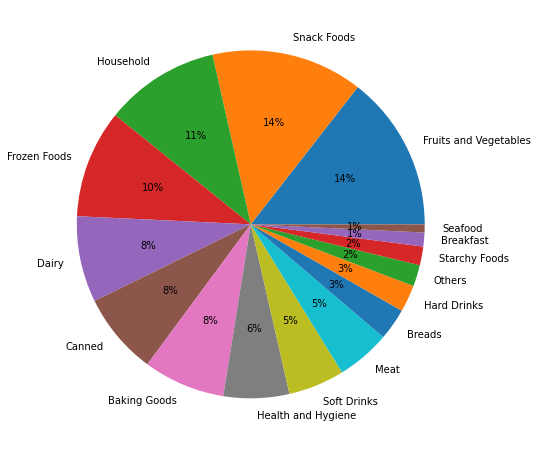

In [27]:
a = big_mart['Item_Type'].value_counts()
plt.figure(figsize = (8,8))
plt.pie(x = a, data=big_mart ,labels= a.index,autopct='%.0f%%')
plt.show()

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

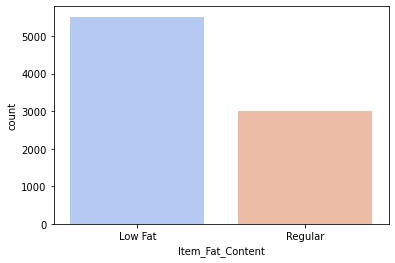

In [28]:
plt.figure(figsize = (6,4))
sns.countplot('Item_Fat_Content', data = big_mart, palette='coolwarm')

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

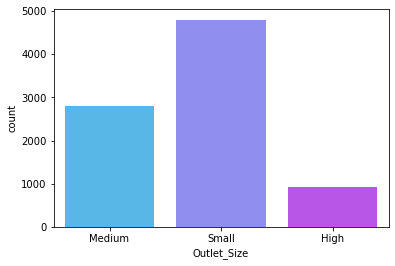

In [29]:
plt.figure(figsize = (6,4))
sns.countplot('Outlet_Size', data = big_mart,palette='cool')

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

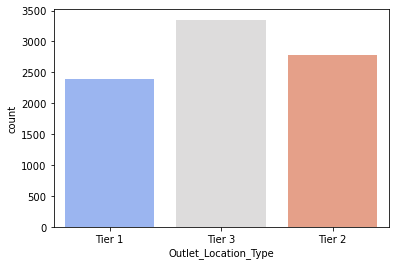

In [30]:
plt.figure(figsize = (6,4))
sns.countplot('Outlet_Location_Type', data = big_mart,palette='coolwarm')

<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

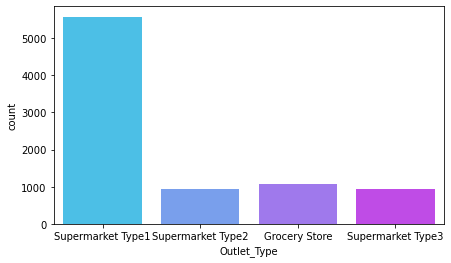

In [31]:
plt.figure(figsize = (7,4))
sns.countplot('Outlet_Type', data = big_mart, palette = 'cool')

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

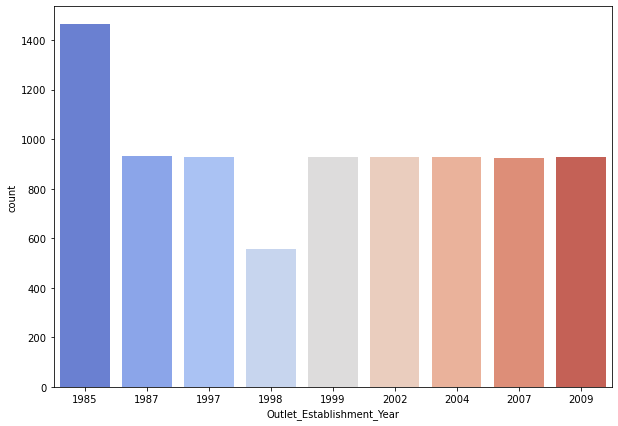

In [32]:
plt.figure(figsize = (10,7))
sns.countplot('Outlet_Establishment_Year', data = big_mart, palette='coolwarm')

##### Bivariate Analysis

Item Outlet Sales vs Item Type

<AxesSubplot:xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

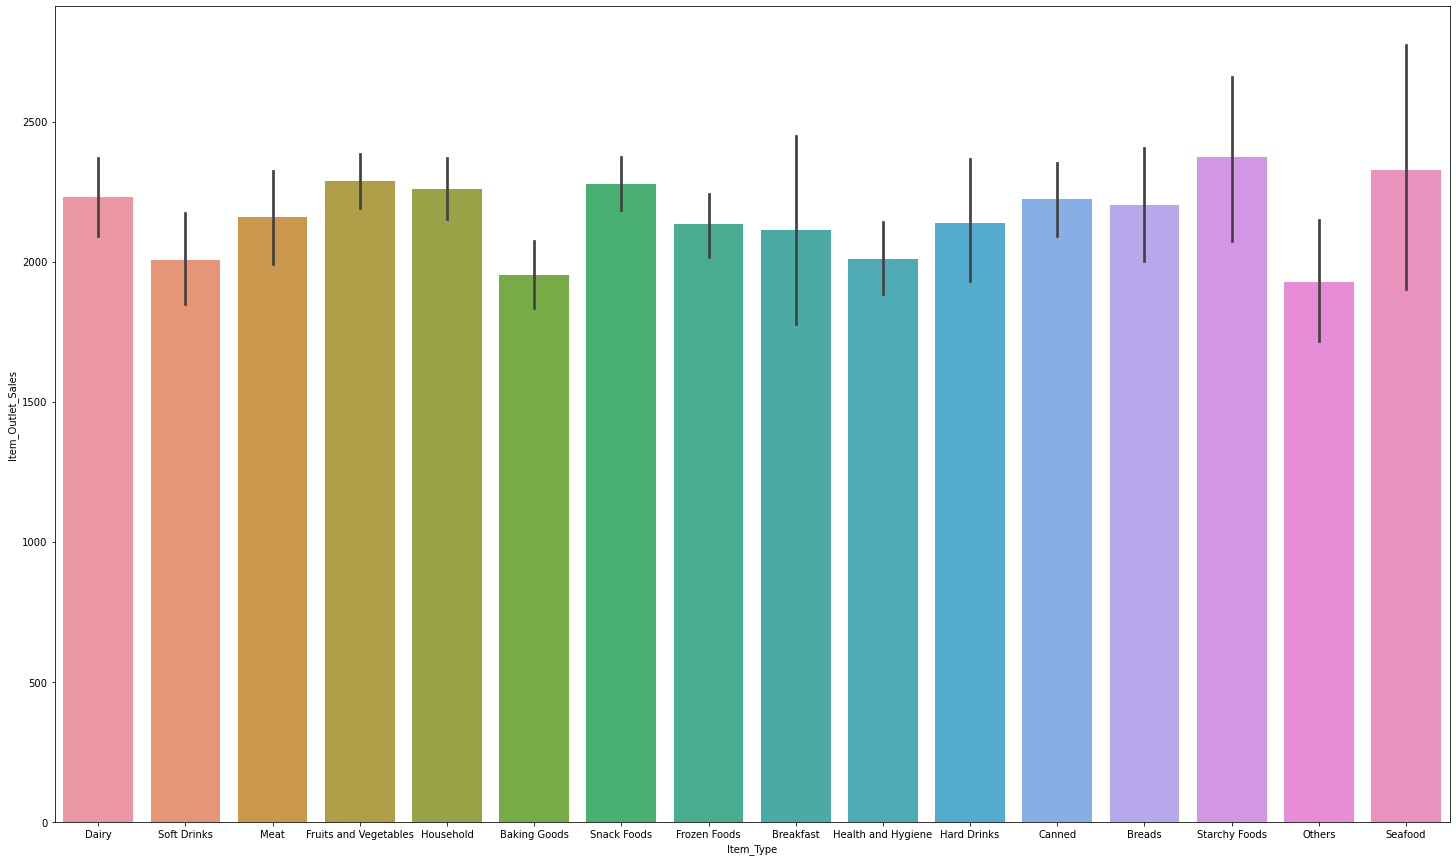

In [33]:
plt.figure(figsize = (25,15))
sns.barplot(y="Item_Outlet_Sales", x="Item_Type", data=big_mart)

Text(0, 0.5, 'Item Visibility')

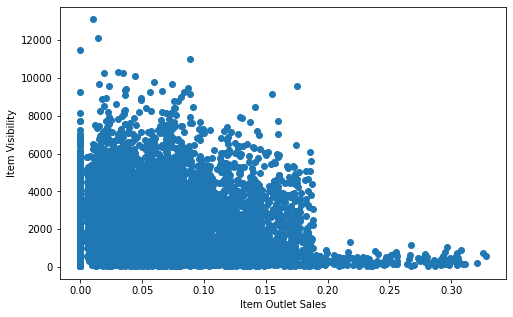

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(x='Item_Visibility',y='Item_Outlet_Sales',data=big_mart)
plt.xlabel('Item Outlet Sales')
plt.ylabel('Item Visibility')

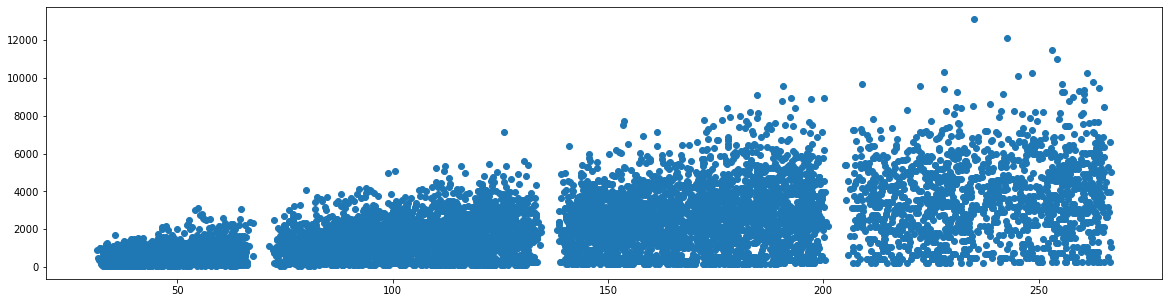

In [35]:
plt.figure(figsize =(20,5))
plt.scatter(x = 'Item_MRP', y = 'Item_Outlet_Sales',data = big_mart )

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

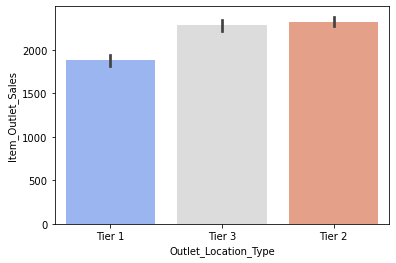

In [36]:
plt.figure(figsize = (6,4))
sns.barplot(x = 'Outlet_Location_Type',y = 'Item_Outlet_Sales',data =  big_mart,palette='coolwarm')

<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

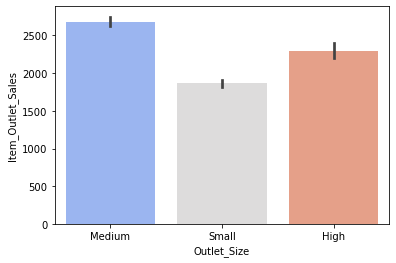

In [37]:
plt.figure(figsize = (6,4))
sns.barplot(x = 'Outlet_Size',y = 'Item_Outlet_Sales',data =  big_mart,palette='coolwarm')


<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

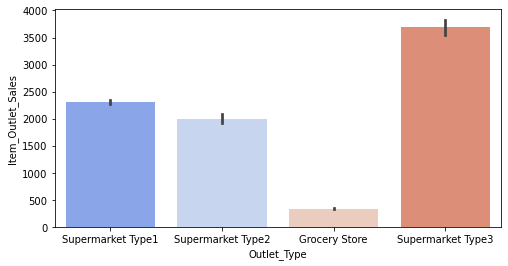

In [38]:
plt.figure(figsize = (8,4))
sns.barplot(x = 'Outlet_Type',y = 'Item_Outlet_Sales',data =  big_mart,palette='coolwarm')

In [39]:
df = pd.DataFrame(big_mart.corr().iloc[:,-1])
df

,Item_Outlet_Sales
Item_Weight,0.012088
Item_Visibility,-0.128625
Item_MRP,0.567574
Outlet_Establishment_Year,-0.049135
Item_Outlet_Sales,1.000000


<AxesSubplot:>

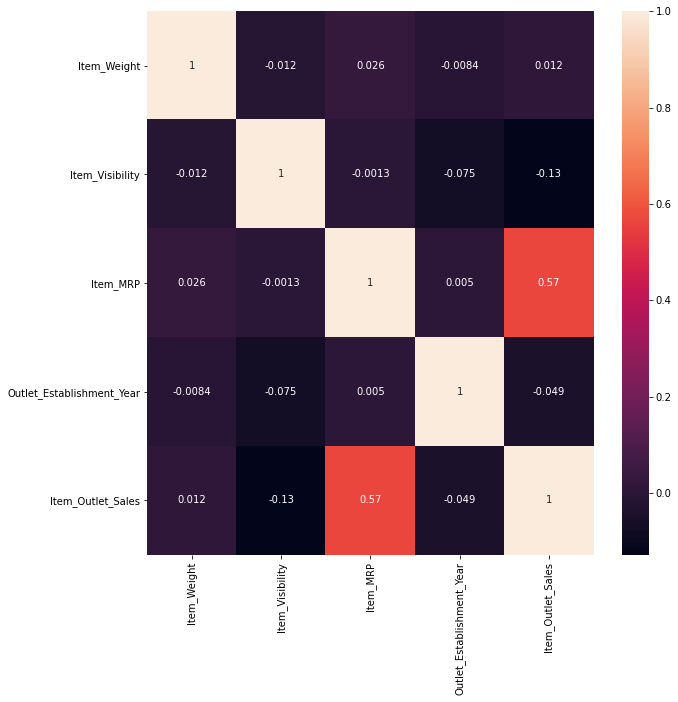

In [40]:
plt.figure(figsize = (10,10))
sns.heatmap(big_mart.corr(),annot = True)

Label Encoding

- We convert the categorical data type columns into numeric type

In [41]:
encoder = LabelEncoder()

In [42]:
big_mart.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [43]:
for col in big_mart[['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']].columns:
    big_mart[col] = encoder.fit_transform( big_mart[col])


In [44]:
big_mart.drop(['Item_Identifier','Outlet_Identifier',],axis=1,inplace = True)

 ###### Feature and Target & Train Test Split

In [45]:
X = big_mart.drop('Item_Outlet_Sales',axis = 1)
Y = big_mart['Item_Outlet_Sales']

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [47]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 9) (6818, 9) (1705, 9)


In [48]:
model1 = XGBRegressor(n_estimators = 100)

In [49]:
model1.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
model1.score(X_train,Y_train)

0.8533887363684853

In [51]:
Y_train_pred = model1.predict(X_train)

In [52]:
metrics.r2_score(Y_train, Y_train_pred)

0.8533887363684853

In [53]:
Y_test_pred = model1.predict(X_test)

In [54]:
metrics.r2_score(Y_test,Y_test_pred)

0.5254418662277596

##### Feature Importance

In [55]:
model1.feature_importances_

array([0.01280831, 0.01217459, 0.01689652, 0.01636672, 0.08822766,
       0.07187625, 0.01733725, 0.01487828, 0.7494344 ], dtype=float32)

In [56]:
feature_importance = pd.DataFrame({'importance': model1.feature_importances_},index = X.columns).sort_values('importance')

In [57]:
feature_importance

,importance
Item_Fat_Content,0.012175
Item_Weight,0.012808
Outlet_Location_Type,0.014878
Item_Type,0.016367
Item_Visibility,0.016897
Outlet_Size,0.017337
Outlet_Establishment_Year,0.071876
Item_MRP,0.088228
Outlet_Type,0.749434


<AxesSubplot:>

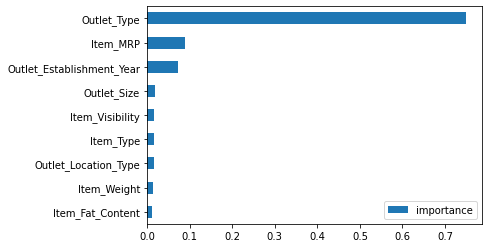

In [58]:
feature_importance.plot.barh()

In [59]:
big_mart_= big_mart[[
'Item_Visibility',
'Outlet_Size',
'Item_MRP',
'Outlet_Type','Item_Outlet_Sales']]

In [60]:
x = big_mart_[[
'Item_Visibility',
'Outlet_Size',
'Item_MRP',
'Outlet_Type']]
y = big_mart_['Item_Outlet_Sales']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=2)

In [62]:
model1.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [63]:
model1.score(x_train,y_train)

0.8202970602046755

In [64]:
y_test_pred = model1.predict(x_test)

In [65]:
metrics.r2_score(y_test,y_test_pred)

0.544661029267582

#### The model has succumbed to overfitting, I have used feature importance to improve the model which has slightly improved the model.